In [103]:
%run -i '../MARIOS/PyFiles/imports.py'
%run -i '../MARIOS/PyFiles/helpers.py'
%run -i "../MARIOS/PyFiles/experiment.py"

In [172]:
#TODO: Step 2: store hyper-parameter-results: Let's get some nice hyper-parameter plots.
#TODO: Step 1: check if observers are correct:
#TODO: fix


def check_shape_obs(file = "default"):
    if file == "default":
        nf = get_new_filename(exp = exp, current = True)
    else:
        nf = file
    with open(nf) as json_file: # 'non_exp_w.txt'
        datt = json.load(json_file)
    #datt = non_exp_best_args["dat"]
    #datt["obs_tr"], datt["obs_te"]   = np.array(datt["obs_tr"]), np.array(datt["obs_te"])
    #datt["resp_tr"], datt["resp_te"] = np.array(datt["resp_tr"]), np.array(datt["resp_te"])
    return(datt)

def load_data(file = "default"):
    if file == "default":
        nf = get_new_filename(exp = exp, current = True)
    else:
        nf = file
    with open(nf) as json_file: # 'non_exp_w.txt'
        datt = json.load(json_file)
    #datt = non_exp_best_args["dat"]
    #datt["obs_tr"], datt["obs_te"]   = np.array(datt["obs_tr"]), np.array(datt["obs_te"])
    #datt["resp_tr"], datt["resp_te"] = np.array(datt["resp_tr"]), np.array(datt["resp_te"])
    return(datt)

#experiment.save_json(exp = False)
fp = bp + 'targetKhz:_0.01__obskHz:_0.01.txt'
fp = bp + 'targetKhz:_0.02__obskHz:_0.01.txt'
def topline(spec_path, 
            base_path = "./experiment_results/2k/medium/",
            verbose = False,
            print_filestructure = False):
    
    
    fp = base_path + spec_path
    """
    targetKhz:_0.02__obskHz:_0.01.txt
    │   │   │   ├── targetKhz:_0.5__obskHz:_0.5.txt
    │   │   │   └── targetKhz:_0.5__obskHz:_1.0.txt
    """
    hi = load_data(file = fp)
    if print_filestructure == True:
        for i in hi.keys():
            print(i + "/")

            if type(hi[i]) == dict:

                for j in hi[i].keys():
                    print("    " +j)
    if verbose == True:
        print("DATA STRUCTURE: (it's a dict)")
        print("/n inputs:")
        print(hi["experiment_inputs"])
        print(hi["get_observer_inputs"])

        print("/n key saved values:")
        print(hi["best arguments"])
        print(hi["nrmse"])
    return(hi)

def recover_test_set(json_obj):
    """
    This function exists for an annoying reason: there is a shitty bug in my code.
    A timeline is dropped and surely this is minor if we can just recover the index by exact indices.
    """
    
    experiment_ = EchoStateExperiment(**json_obj["experiment_inputs"])
    
    obs_inputs = json_obj["get_observer_inputs"]
    obs_inputs["method"] = "exact"
    

    
    obs_idx, resp_idx = json_obj["obs_idx"], json_obj["resp_idx"]
    A_subset = experiment_.A.copy()
    
    # pred shape
    pred_shape = np.array(json_obj["prediction"]["uniform"]); pred_shape = pred_shape.shape[0]                   
    
    A = experiment_.A
    
    train_len = (A.shape[0] - pred_shape)
    Train_Tmp, Test_Tmp  = A[:train_len,resp_idx], A[train_len:,resp_idx]
    
    
    
    print(Test_Tmp.shape)
    return(Train_Tmp, Test_Tmp)

recover_test_set(hi)

(103, 101)


(array([[-1.76432165, -1.96366339, -2.28428251, ..., -1.72418028,
         -1.78055042, -1.81110106],
        [-1.87094542, -2.26989665, -2.434243  , ..., -1.56811523,
         -1.65531409, -1.79807118],
        [-2.0380553 , -2.0903722 , -2.00886056, ..., -1.56779946,
         -1.78897763, -2.00997118],
        ...,
        [-0.48837489, -0.58531245, -0.76316399, ..., -0.49113557,
         -0.5036587 , -0.48060818],
        [-0.49604009, -0.43830499, -0.54064169, ..., -0.94362197,
         -0.56172445, -0.73052325],
        [-0.67509625, -0.70075369, -0.95288248, ..., -0.83185956,
         -1.01676354, -1.09813729]]),
 array([[-0.21219163, -0.6036242 , -0.2398714 , ..., -0.3938492 ,
         -0.4102141 , -0.97797866],
        [-0.51082371, -0.77514948, -1.44259632, ..., -0.61703927,
         -0.63859897, -0.96751465],
        [-0.20635641, -0.51886396, -0.60166704, ..., -0.49484232,
         -0.51202859, -0.63479388],
        ...,
        [-1.82404828, -1.98023003, -1.90554492, ..., -

In [173]:
 #GOOD!
hi["get_observer_inputs"]
hi["experiment_inputs"]["obs_hz"] = int( hi["experiment_inputs"]["obs_hz"] * 1000* 1000)
print(hi["experiment_inputs"]["obs_hz"] )
hi["experiment_inputs"]["target_hz"] = int(hi["experiment_inputs"]["target_hz"] * 1000 * 1000)



1000


In [197]:

def compare(truth, 
            unif_w_pred = None, 
            exp_w_pred = None, 
            ip_pred = None,
            columnwise = False,
            verbose = False):
    """
    This function provides two things, conditional on the columnwise variable.
    columnwise = False: cross-model comparison of nrmse
    
    columnwise = True: model nrmse correlary for each point.
    """
    #ip_res =    #runInterpolation(columnwise = columnwise)
    
    if type(unif_w_pred) != type(None):
        unif_nrmse = nrmse(pred_ = unif_w_pred, truth = truth, columnwise = columnwise)
        
    if type(exp_w_pred) != type(None):
        exp_nrmse = nrmse(pred_  = exp_w_pred , truth = truth, columnwise = columnwise)
    
    if type(ip_pred) != type(None):
        ip_nrmse = nrmse(pred_  = ip_pred , truth = truth, columnwise = columnwise)
        
    ip_res = {"nrmse" : ip_nrmse, "pred" : ip_pred}
        
    
    assert type(columnwise) == bool, "columnwise must be a boolean"
    
    if columnwise == False:
        if verbose != False:
            print("cubic spline interpolation nrmse: " + str(ip_res["nrmse"]))
            print("uniform weights rc nrmse: " + str(unif_nrmse))
            print("exponential weights rc nrmse: " + str(exp_nrmse))
            print("creating barplot")
        if type(exp_w_pred) != type(None):
            df = pd.DataFrame({"interpolation" : ip_res["nrmse"], 
                               "uniform rc" : unif_nrmse, 
                               "exponential rc" : exp_nrmse}, index = [0])
        else:
            df = pd.DataFrame({"interpolation" : ip_res["nrmse"], 
                               "uniform rc" : unif_nrmse}, index = [0])
        display(df)

        plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
        sns.catplot(data = df, kind = "bar")
        plt.title("model vs nrmse")
        plt.ylabel("nrmse")
        improvement = []
        for rc_nrmse in[unif_nrmse, exp_nrmse]:
            impr_spec = ((ip_res["nrmse"] - rc_nrmse)/ip_res["nrmse"]) * 100
            impr_spec = [round(impr_spec,1)]
            improvement += impr_spec

        pct_improve_unif, pct_improve_exp = improvement
        if pct_improve_unif > 0:
            print("unif improvement vs interpolation: nrmse " + str(-pct_improve_unif) + "%")
        else:
            print("rc didn't beat interpolation: nrmse +" + str(-pct_improve_unif) + "%")
        
        if pct_improve_exp > 0:
            print("exp improvement vs interpolation: nrmse " + str(-pct_improve_exp) + "%")
        else:
            print("rc didn't beat interpolation: nrmse +" + str(-pct_improve_exp) + "%")

        impr_rc_compare = round(((unif_nrmse - exp_nrmse)/unif_nrmse) * 100,1)

        if impr_rc_compare > 0:
            print("exp rc improvement vs unif rc: nrmse " + str(-impr_rc_compare) + "%")
        else:
            print("exp weights didn't improve rc: nrmse +" + str(-impr_rc_compare) + "%")
    else:
        print("creating first figure")
        model_names = ["interpolation", "uniform rc", "exponential rc"]
        for i, model_rmse_np in enumerate([ip_res["nrmse"], unif_nrmse, exp_nrmse]):
            model_rmse_pd = pd.melt(pd.DataFrame(model_rmse_np.T))
            model_rmse_pd.columns = ["t","y"]
            model_rmse_pd["model"] = model_names[i]
            if i == 0:
                models_pd = model_rmse_pd
            else:
                models_pd = pd.concat([models_pd, model_rmse_pd ], axis = 0)
        fig, ax = plt.subplots(1,1, figsize = (11, 6))
        sns.lineplot(x = "t", y = "y", hue = "model", data = models_pd, ax = ax)
        ax.set_title("model vs rmse")
        ax.set_ylabel("nrmse")
        ax.set_xlabel("Test idx")
        
def get_experiment(json_obj, verbose = False):
    
    experiment_ = EchoStateExperiment(**json_obj["experiment_inputs"])
    
    obs_inputs = json_obj["get_observer_inputs"]
    obs_inputs["method"] = "exact"
    
    experiment_.obs_idx, experiment_.resp_idx  = json_obj["obs_idx"], json_obj["resp_idx"]
    
    experiment_.get_observers(**obs_inputs, 
                              plot_split = True)
    if verbose == True:
        print("experiment inputs: " + str(json_obj["experiment_inputs"]))
        print("get_obs_inputs: " + str(obs_inputs))
        print("Train.shape: " + str(experiment_.Train.shape))
        print("Saved_prediction.shape: " + str(np.array(json_obj["prediction"]["uniform"]).shape))
        
        
    
        
    experiment_.already_trained(json_obj["best arguments"]["uniform"])
    print(experiment_.prediction.shape)
    print(experiment_.Test.shape)
    
    
    experiment_.Train, experiment_.Test = recover_test_set(json_obj)
    ### which line is missing?
    xx = range(experiment_.prediction.shape[0])
    
    
    #plt.imshow( experiment_.prediction)
    #plt.show()
    """
    #plt.imshow( experiment_.Test)
    #plt.show()
    
    sns.lineplot( x = xx, y = experiment_.prediction[ : , 0 ], label = "prediction from cluster 0 ")
    sns.lineplot( x = xx, y = experiment_.prediction[ : , 0 ], label = "prediction from cluster 1 ")
    sns.lineplot( x = xx, y = experiment_.Test[ : , 0 ], label = "actual data 0")
    sns.lineplot( x = xx, y = experiment_.Test[ : , -1 ], label = "actual data 1")
    #plt.plot(experiment_.Test[ : , 1 ])
    """
    
    #experiment_.plot_timeseries(method = "avg")
    
    if len(list(json_obj["prediction"].keys())) == 3:
        compare(
            truth       = np.array(experiment_.Test), 
            unif_w_pred = np.array(json_obj["prediction"]["uniform"]),
            ip_pred = np.array(json_obj["prediction"]["interpolation"]),
            exp_w_pred  = np.array(json_obj["prediction"]["exponential"]), 
            columnwise  = False,
            verbose = False)
    if len(list(json_obj["prediction"].keys())) == 2:
        compare(
            truth       = np.array(experiment_.Test), 
            unif_w_pred = np.array(json_obj["prediction"]["uniform"]),
            ip_pred = np.array(json_obj["prediction"]["interpolation"]),
            exp_w_pred  = None,#np.array(json_obj["prediction"]["exponential"]), 
            columnwise  = False,
            verbose = False)

    return(experiment_)
    
       
        #return(df)


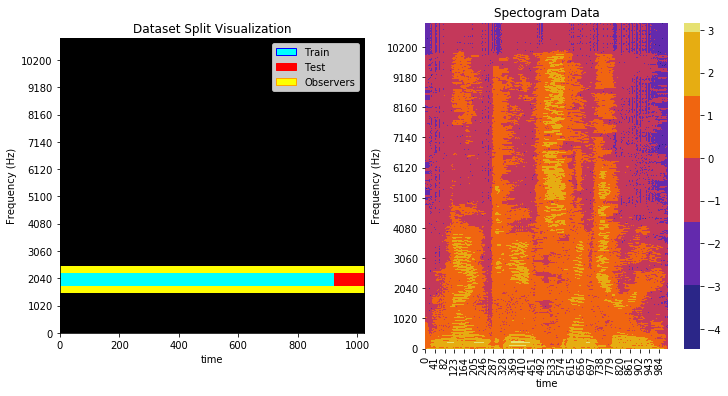

(103, 51)
(103, 52)
(103, 51)


,interpolation,uniform rc,exponential rc
0,0.039552,0.008456,0.008444


unif improvement vs interpolation: nrmse -78.6%
exp improvement vs interpolation: nrmse -78.7%
exp rc improvement vs unif rc: nrmse -0.1%


<Figure size 640x480 with 0 Axes>

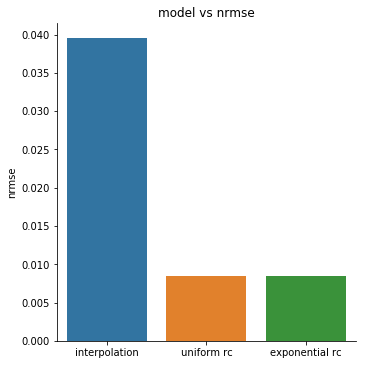

In [198]:
hi= topline("split_0.9/targetKhz:_0.5__obskHz:_0.5.txt", print_filestructure = False)
get_experiment(hi)

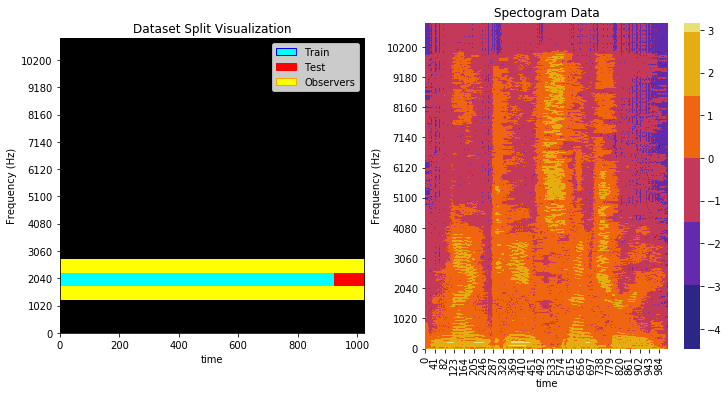

(103, 51)
(103, 102)
(103, 51)


,interpolation,uniform rc,exponential rc
0,0.039095,0.013464,0.009401


unif improvement vs interpolation: nrmse -65.6%
exp improvement vs interpolation: nrmse -76.0%
exp rc improvement vs unif rc: nrmse -30.2%


<Figure size 640x480 with 0 Axes>

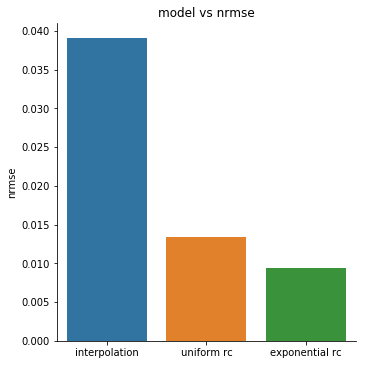

In [199]:
hi = topline("split_0.9/targetKhz:_0.5__obskHz:_1.0.txt") 
get_experiment(hi)

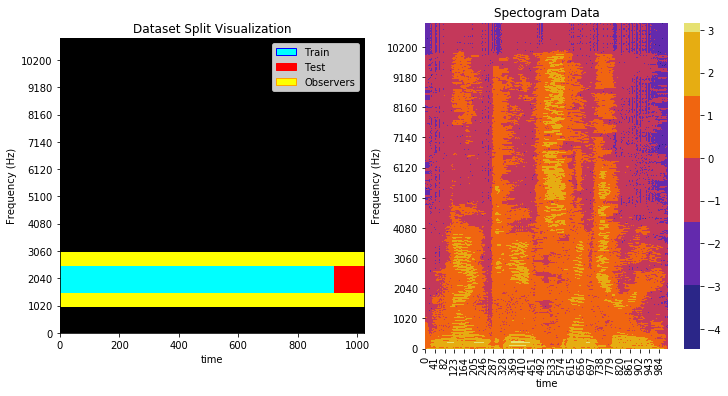

(103, 101)
(103, 102)
(103, 101)


,interpolation,uniform rc
0,0.039351,0.005177


UnboundLocalError: local variable 'exp_nrmse' referenced before assignment

<Figure size 640x480 with 0 Axes>

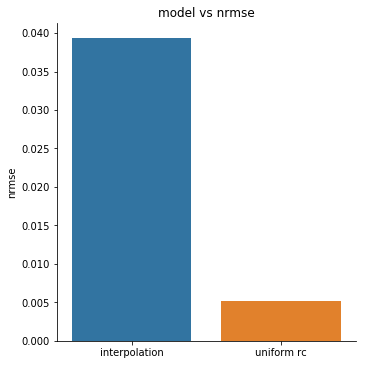

In [200]:
hi = topline("split_0.9/targetKhz:_1.0__obskHz:_1.0.txt")  #GOOD!
get_experiment(hi)

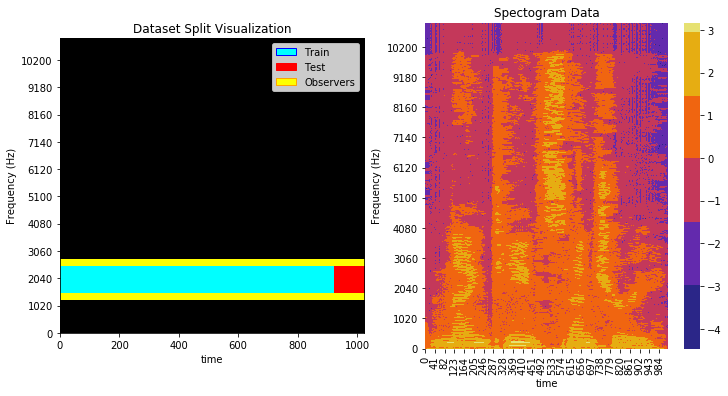

(103, 101)
(103, 52)
(103, 101)


,interpolation,uniform rc
0,0.040547,0.004824


UnboundLocalError: local variable 'exp_nrmse' referenced before assignment

<Figure size 640x480 with 0 Axes>

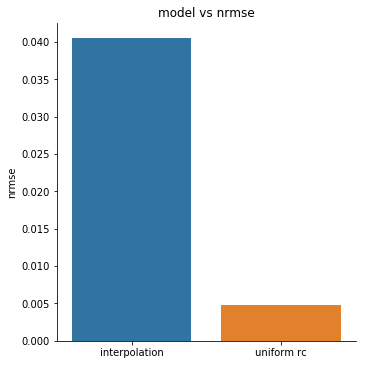

In [202]:
hi = topline("split_0.9/targetKhz:_1.0__obskHz:_0.5.txt")  #GOOD!
get_experiment(hi)

In [209]:
hi = load_data("experiment_results/2k/medium/split_0.5/targetKhz:_0.5__obskHz:_1.0.txt")#topline("split_0.5/targetKhz:_0.5__obskHz:_1.0.txt")  #GOOD!
hi["nrmse"]

{'interpolation': 0.03141803605667493, 'exponential': 0.007618104198483177}

In [205]:
hi = topline("split_0.5/targetKhz:_0.5__obskHz:_0.5.txt")  #GOOD!
#get_experiment(hi)
hi["nrmse"]

{'interpolation': 0.0319256222664088, 'uniform': 0.007221831402491996}